##Traffic Sign Classification Using RESNET34

In [1]:
!nvidia-smi

Sat Sep 24 19:21:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q -U watermark

     |████████████████████████████████| 1.6 MB 35.0 MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision

Python implementation: CPython
Python version       : 3.7.14
IPython version      : 7.9.0

numpy      : 1.21.6
pandas     : 1.3.5
torch      : 1.12.1+cu113
torchvision: 0.13.1+cu113



In [ ]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Recognizing traffic signs

[German Traffic Sign Recognition Benchmark (GTSRB)](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) contains more than 50,000 annotated images of 40+ traffic signs. Given an image, you'll have to recognize the traffic sign on it.



In [ ]:
# Retrieving dataset 
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2022-09-24 19:00:58--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  14.2MB/s    in 21s     

2022-09-24 19:01:20 (12.8 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



### Exploration

The images for each traffic sign are stored in a separate directory.

In [ ]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

43

We'll create 3 helper functions that use OpenCV and Torchvision to load  and show images:

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA) #resize the image to 64x64

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

# To plot a traffic sign grid with different signs
def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)  # converting all images to a single tensor
  images = images.permute(0, 3, 1, 2) # 3-BLUE 1-RED 2-GREEN Covers
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

examples for each traffic sign:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  app.launch_new_instance()


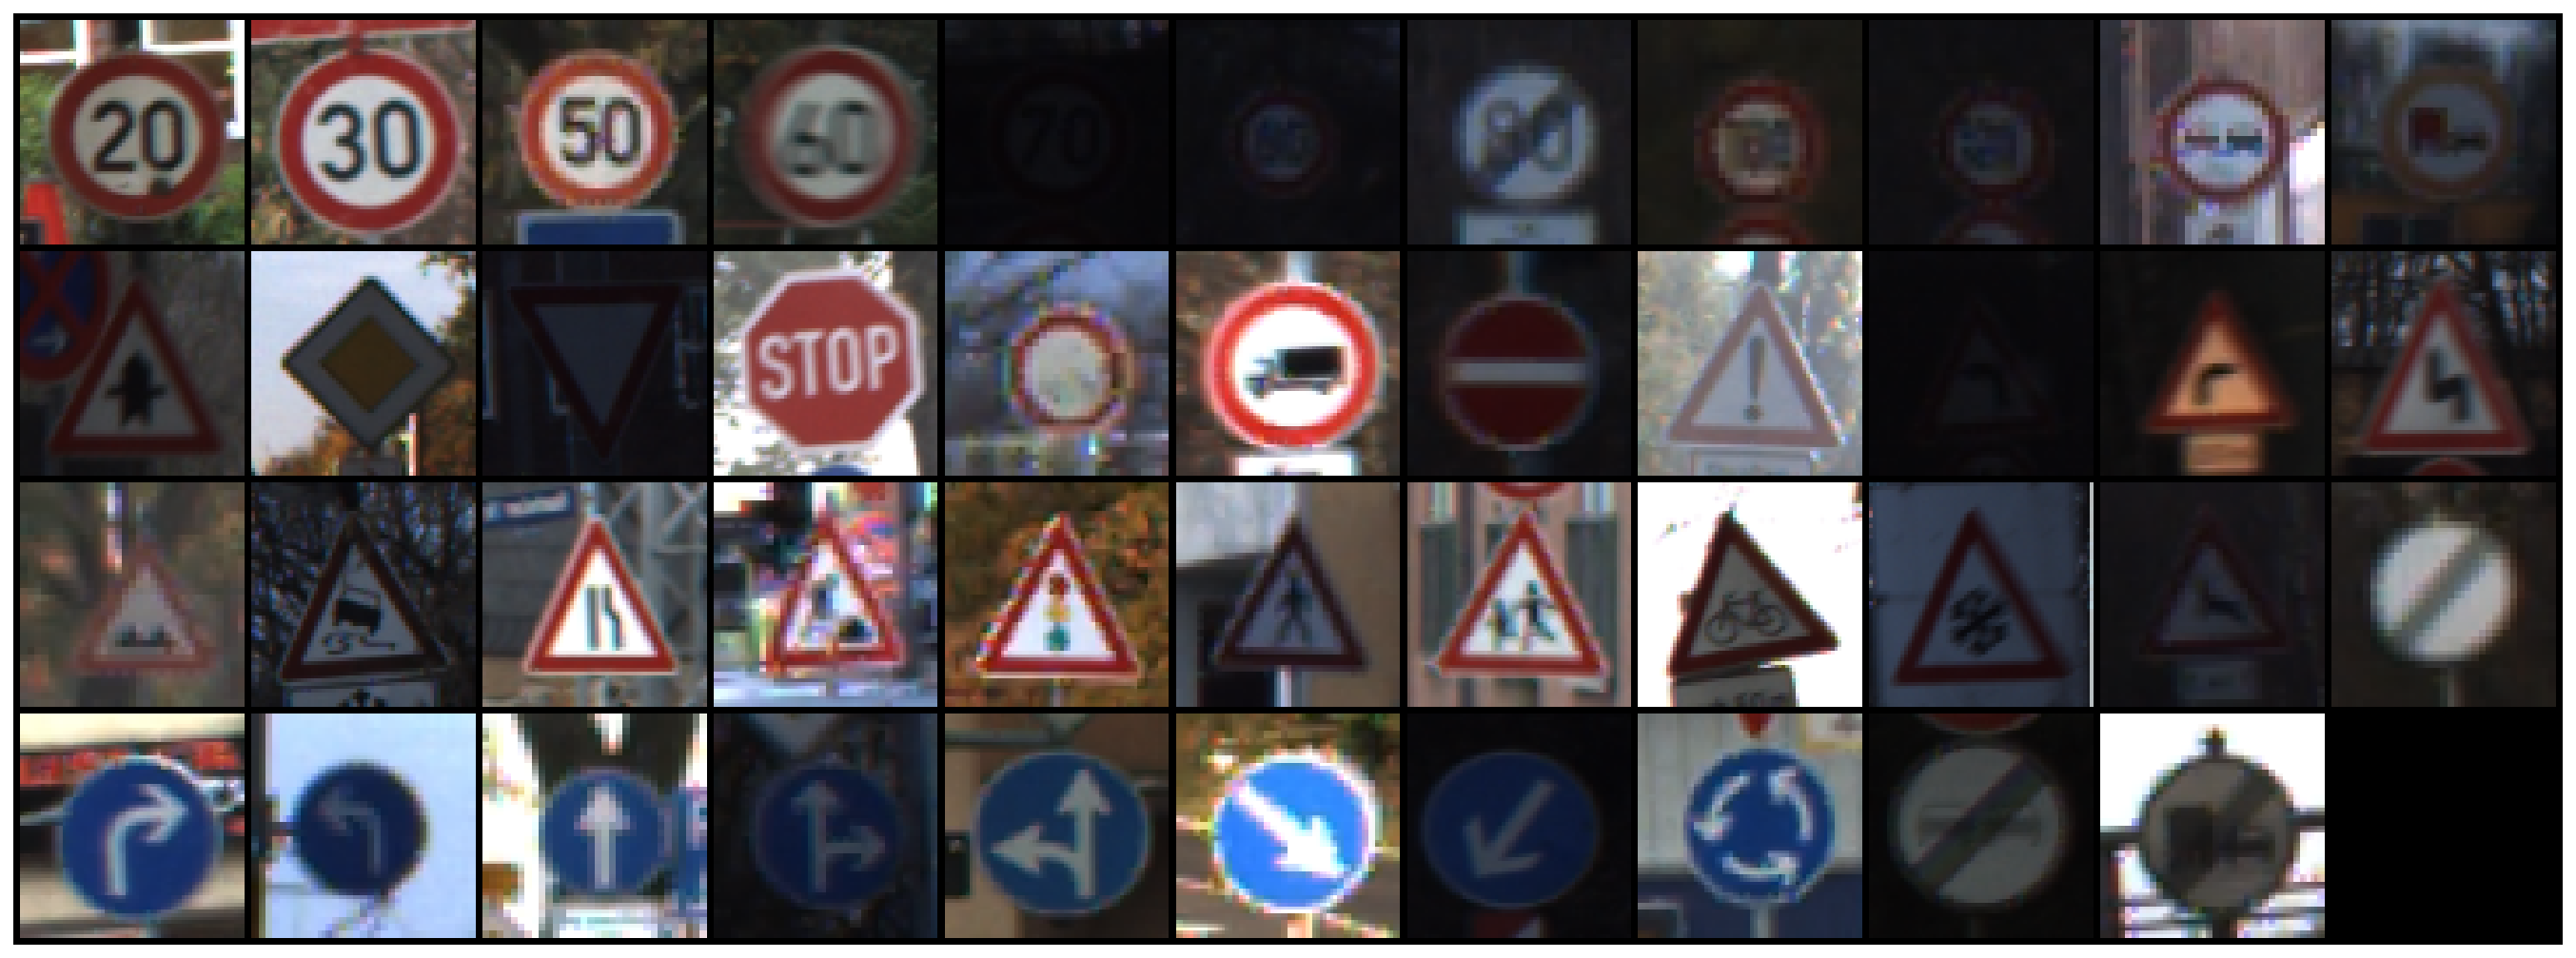

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders] 
show_sign_grid(sample_images)

A single sign:

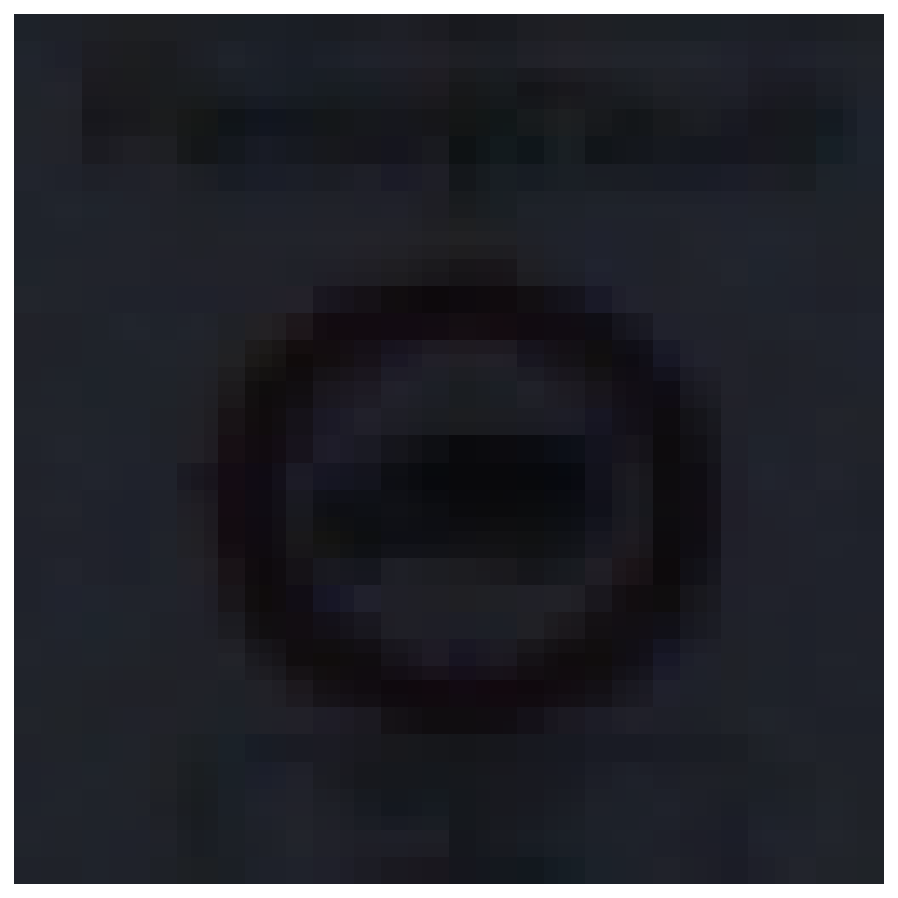

In [ ]:
img_path = glob(f'{train_folders[16]}/*ppm')[1]

show_image(img_path)

## Building a dataset

To keep things simple, we'll focus on classifying some of the most used traffic signs:

In [ ]:
class_names = ['priority_road', 'give_way', 'stop', 'no_entry']

class_indices = [12, 13, 14, 17]
# The indices are the folder-wise representation in the dataset with-respect to labels

We'll copy the images files to a new directory.

In [ ]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val', 'test']
# creating data folders with each folder names (train, val, test) and subfolders with class names (no_entry, stop,... etc)
for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)  

We'll reserve 80% of the images for training, 10% for validation, and 10% test for each class. We'll copy each image to the correct dataset directory:

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  
  # Shuffling the images
  np.random.shuffle(image_paths)

  """
  Train,val, test split
  0.8 -> in Train set
  0.9-0.8 = .1 -> Validation Set
  Remaining (0.1) -> Test Set
  """
  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110


We have some class imbalance, but it is not that bad. We'll ignore it.

We'll apply some image augmentation techniques to artificially increase the size of our training dataset:

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
 
transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

We apply some random resizing, rotation, and horizontal flips. Finally, we normalize the tensors using preset values for each channel.

We'll create a PyTorch dataset for each image dataset folder and data loaders for easier training:

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

# 'num_workers' tells the data loader instance how many sub-processes to use for data loading
data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


We'll also store the number of examples in each dataset and class names for later:

In [ ]:
# Get dataset size
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 4920, 'val': 615, 'test': 615}

some example images with applied transformations.

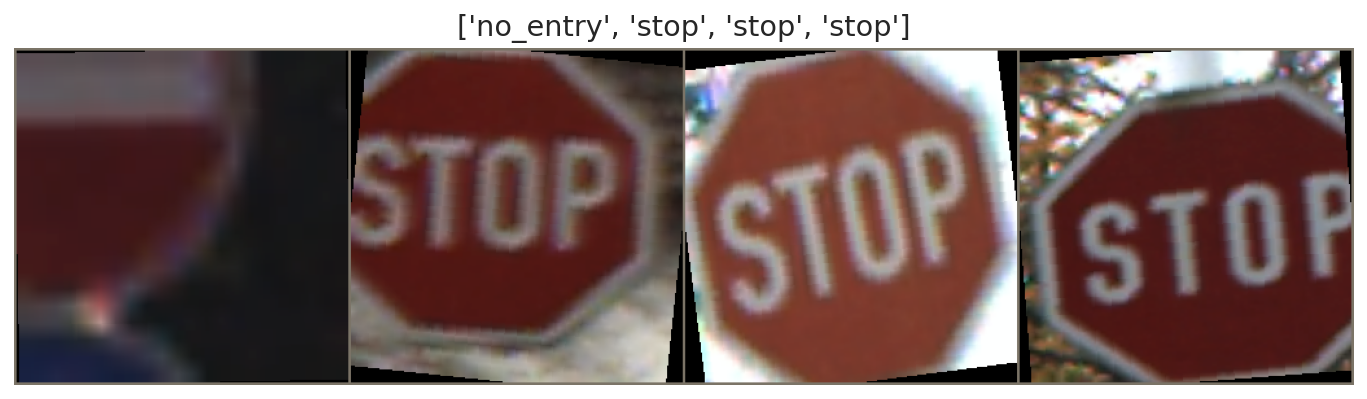

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Using a pre-trained model:

Our model will receive raw image pixels and try to classify them into one of four traffic signs. How hard can it be? Try to build a model from scratch.

Here, we'll use Transfer Learning to copy the architecture of the very popular ResNet model.

In [ ]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True) # Already trained model

  n_features = model.fc.in_features  # size of each input sample
  model.fc = nn.Linear(n_features, n_classes) # replacing the fully connceted layer

  return model.to(device)

# replace the fully connected layer with a linear layer has 'num_class' as output
# linear layer expect a number of feature.

Create an instance of our model:

In [ ]:
base_model = create_model(len(class_names))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

### Training

helper functions to encapsulate the training and evaluation. `train_epoch`:

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# def train_epoch(
#   model, 
#   data_loader, 
#   loss_fn, 
#   optimizer, 
#   device, 
#   scheduler, 
#   n_examples
# ):
#   model = model.train()

#   losses = []
#   correct_predictions = 0
  
#   for inputs, labels in data_loader:
#     inputs = inputs.to(device)
#     labels = labels.to(device)

#     outputs = model(inputs)

#     _, preds = torch.max(outputs, dim=1)
#     loss = loss_fn(outputs, labels)

#     correct_predictions += torch.sum(preds == labels)
#     losses.append(loss.item())

#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()

#   scheduler.step()

#   pred_tickets = correct_predictions.double() / n_examples
#   print(f"pred_tickets :  {pred_tickets}")
  
#   res_preds = pred_tickets.cpu().data.numpy()  
#   print(f"res_preds :  {res_preds}")


#   print(f"np.mean(losses) :  {np.mean(losses)}")
  
#   losses_cuda = torch.Tensor(losses).cpu().data.numpy()  
#   print(f"losses_cuda :  {losses_cuda}")
  
#   losses_cuda_mean = losses_cuda.mean()
#   print(f"losses_cuda_mean :  {losses_cuda_mean}")

#   return res_preds, losses_cuda_mean

We start by turning our model into train mode and go over the data. After getting the predictions, we get the class with maximum probability along with the loss, so we can calculate the epoch loss and accuracy.

we're also using a learning rate scheduler (A Learning rate scheduler is a predefined framework that adjusts the learning rate between epochs or iterations as the training progresses, It find the optimal learning rate for various models by conisdering the model architecture and parameters) 
[Learning rate scheduler](https://neptune.ai/blog/how-to-choose-a-learning-rate-scheduler)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) 
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

train our model:

In [ ]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/3
----------
Train loss 0.33114092204185264 accuracy 0.8857723577235772
Val   loss 0.003248802173874236 accuracy 1.0

Epoch 2/3
----------
Train loss 0.09636809561039346 accuracy 0.9684959349593496
Val   loss 0.0013753621545717649 accuracy 1.0

Epoch 3/3
----------
Train loss 0.0970450737255039 accuracy 0.9699186991869919
Val   loss 0.010733453170846499 accuracy 0.9967479674796748

Best val accuracy: 1.0
CPU times: user 2min 13s, sys: 6.44 s, total: 2min 19s
Wall time: 2min 30s


helper function that visualizes the training history

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  print(f"history['train_acc'] : {history['train_acc']}")  
  print(f"history['val_acc'] : {history['val_acc']}")  


  train_accuracy_list = [tensor.item() for tensor in history['train_acc']]
  validation_accuracy_list = [tensor.item() for tensor in history['val_acc']]

  print(f"train_accuracy_list : {train_accuracy_list}")
  print(f"validation_accuracy_list : {validation_accuracy_list}")

  ax2.plot(train_accuracy_list, label='train accuracy')
  ax2.plot(validation_accuracy_list, label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

history['train_acc'] : [tensor(0.8858, device='cuda:0', dtype=torch.float64), tensor(0.9685, device='cuda:0', dtype=torch.float64), tensor(0.9699, device='cuda:0', dtype=torch.float64)]
history['val_acc'] : [tensor(1., device='cuda:0', dtype=torch.float64), tensor(1., device='cuda:0', dtype=torch.float64), tensor(0.9967, device='cuda:0', dtype=torch.float64)]
train_accuracy_list : [0.8857723577235772, 0.9684959349593496, 0.9699186991869919]
validation_accuracy_list : [1.0, 1.0, 0.9967479674796748]


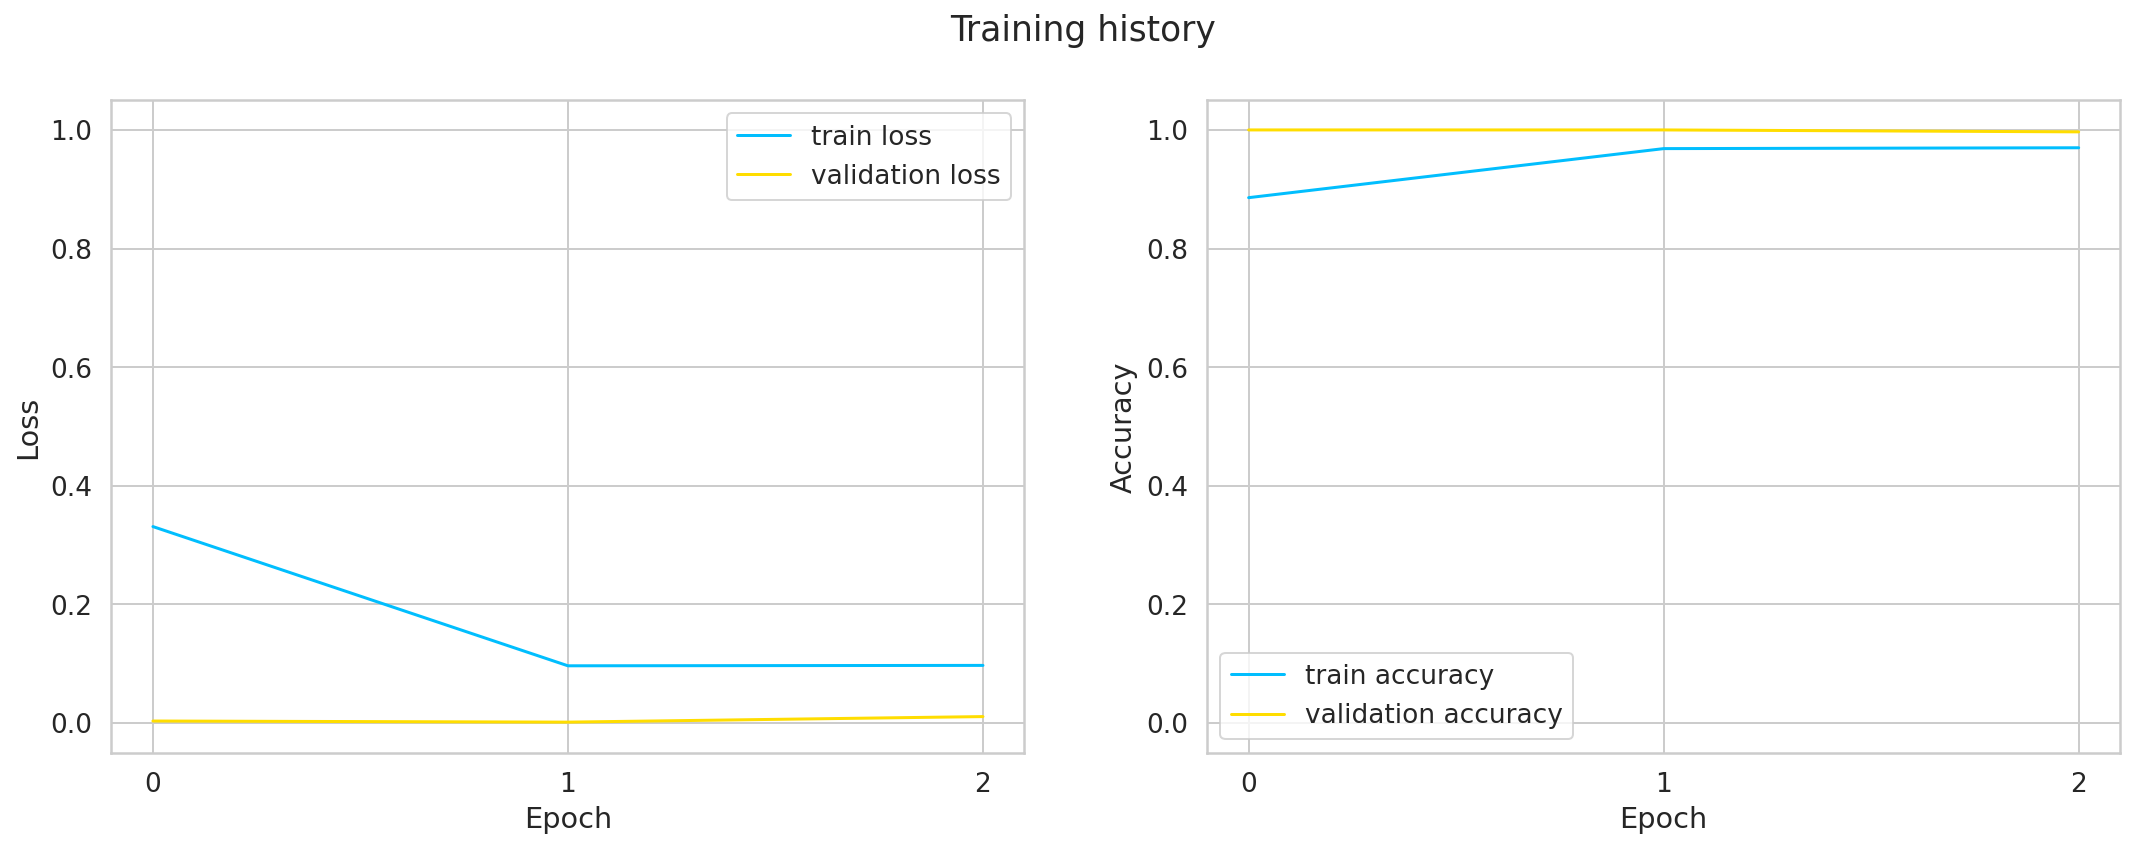

In [ ]:
plot_training_history(history)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# def plot_training_history(history):
#   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

#   ax1.plot(history['train_loss'], label='train loss')
#   ax1.plot(history['val_loss'], label='validation loss')

#   ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
#   ax1.set_ylim([-0.05, 1.05])
#   ax1.legend()
#   ax1.set_ylabel('Loss')
#   ax1.set_xlabel('Epoch')

#   print(f"history['train_acc'] : {history['train_acc']}")  
#   print(f"history['val_acc'] : {history['val_acc']}")  

#   for tensor in history['train_acc']

#   result = [tensor.item() for tensor in history['train_acc']]

#   ax2.plot(float(history['train_acc']), label='train accuracy')
#   ax2.plot(float(history['val_acc']), label='validation accuracy')

#   ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  
#   ax2.set_ylim([-0.05, 1.05])
#   ax2.legend()

#   ax2.set_ylabel('Accuracy')
#   ax2.set_xlabel('Epoch')

#   fig.suptitle('Training history')

The pre-trained model is so good that we get very high accuracy and low loss after 3 epochs. Unfortunately, our validation set is too small to get some meaningful metrics from it.

### Evaluation

Let's see some predictions on traffic signs from the test set:

In [ ]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

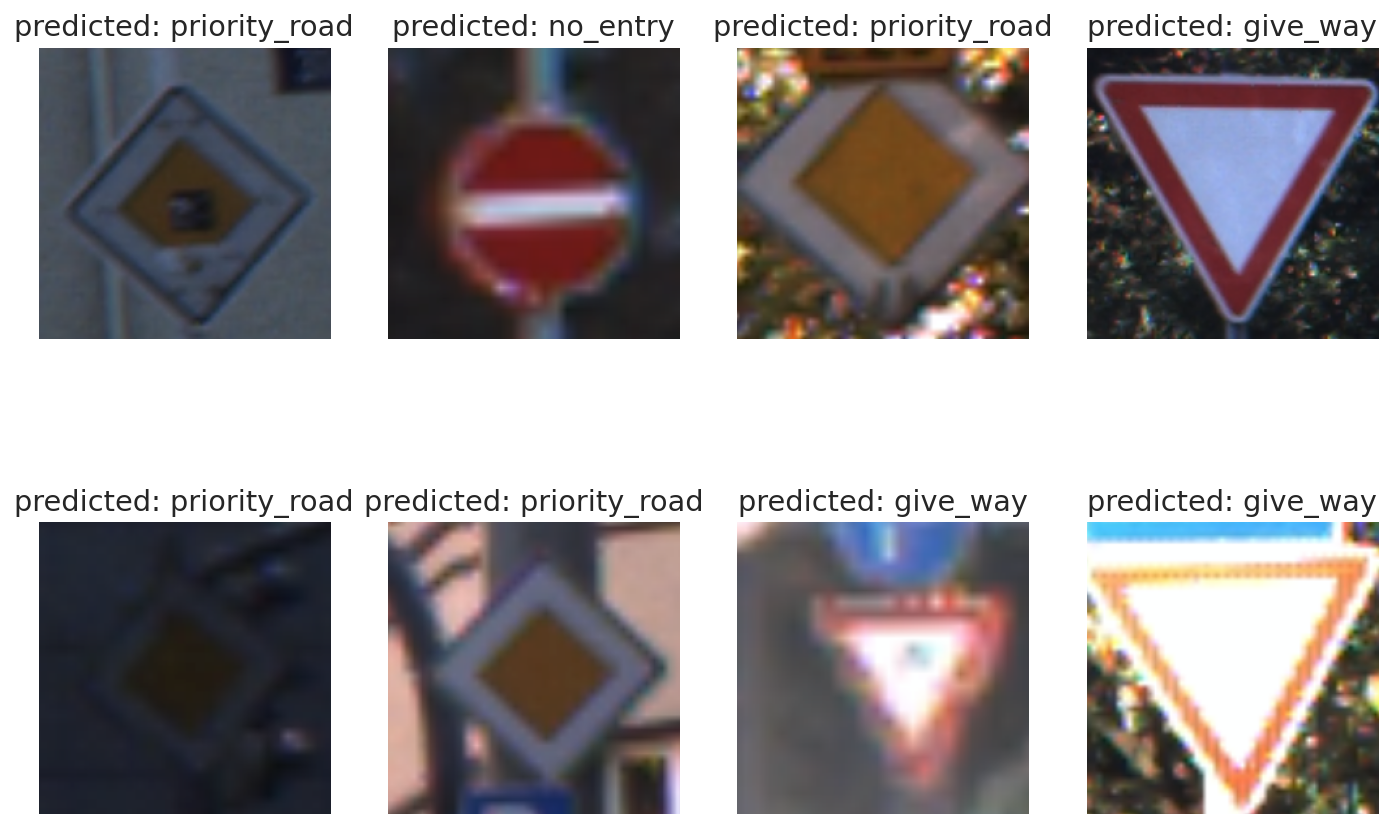

In [ ]:
show_predictions(base_model, class_names, n_images=8)


getting the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

     give_way       1.00      1.00      1.00       216
     no_entry       1.00      1.00      1.00       111
priority_road       1.00      1.00      1.00       210
         stop       1.00      1.00      1.00        78

     accuracy                           1.00       615
    macro avg       1.00      1.00      1.00       615
 weighted avg       1.00      1.00      1.00       615



The classification report shows us that our model is perfect

In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

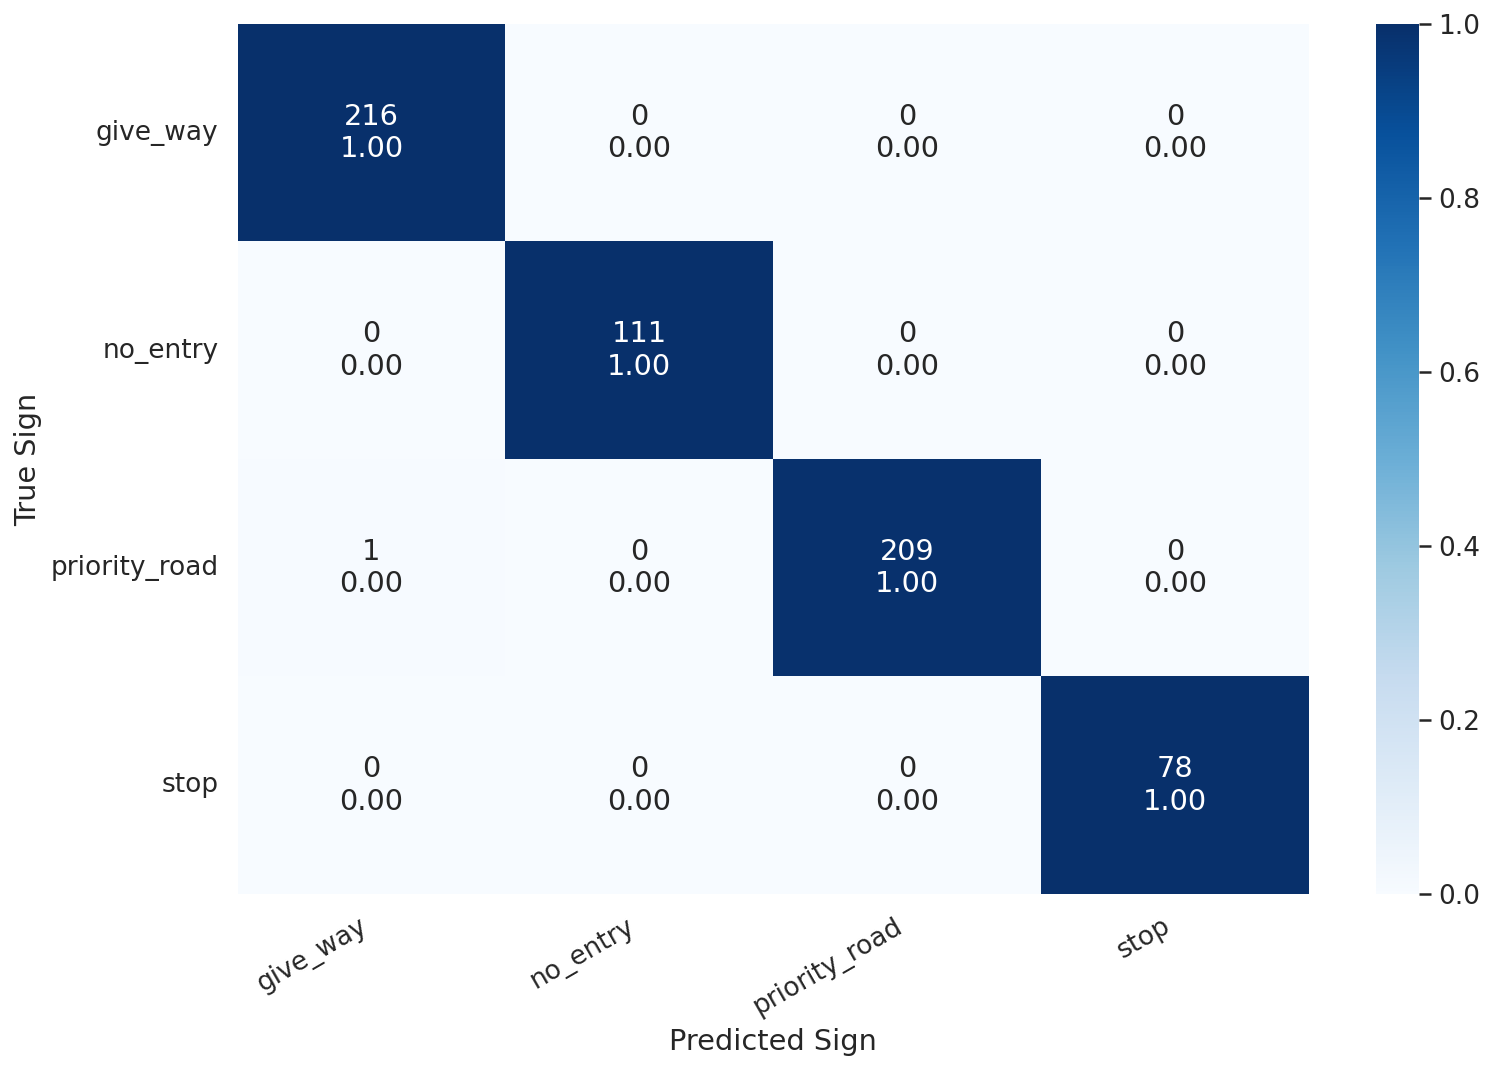

In [ ]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

### Classifying external images

In [ ]:
!gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
To: /content/stop-sign.jpg
100% 77.3k/77.3k [00:00<00:00, 84.0MB/s]


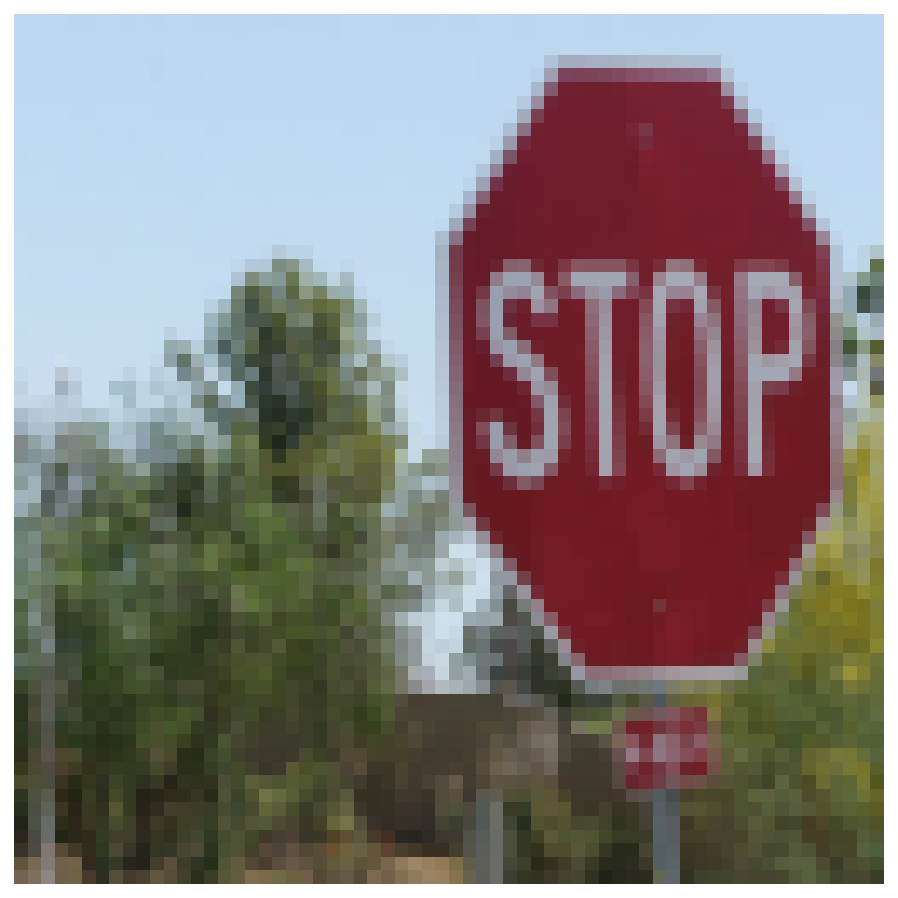

In [ ]:
show_image('stop-sign.jpg')

For this, we'll have a look at the confidence for each class. Let's get this from our model:

In [ ]:
def predict_probabilty(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [ ]:
pred = predict_probabilty(base_model, 'stop-sign.jpg')
pred

array([0.00883232, 0.01418493, 0.0087396 , 0.96824306], dtype=float32)

In [ ]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

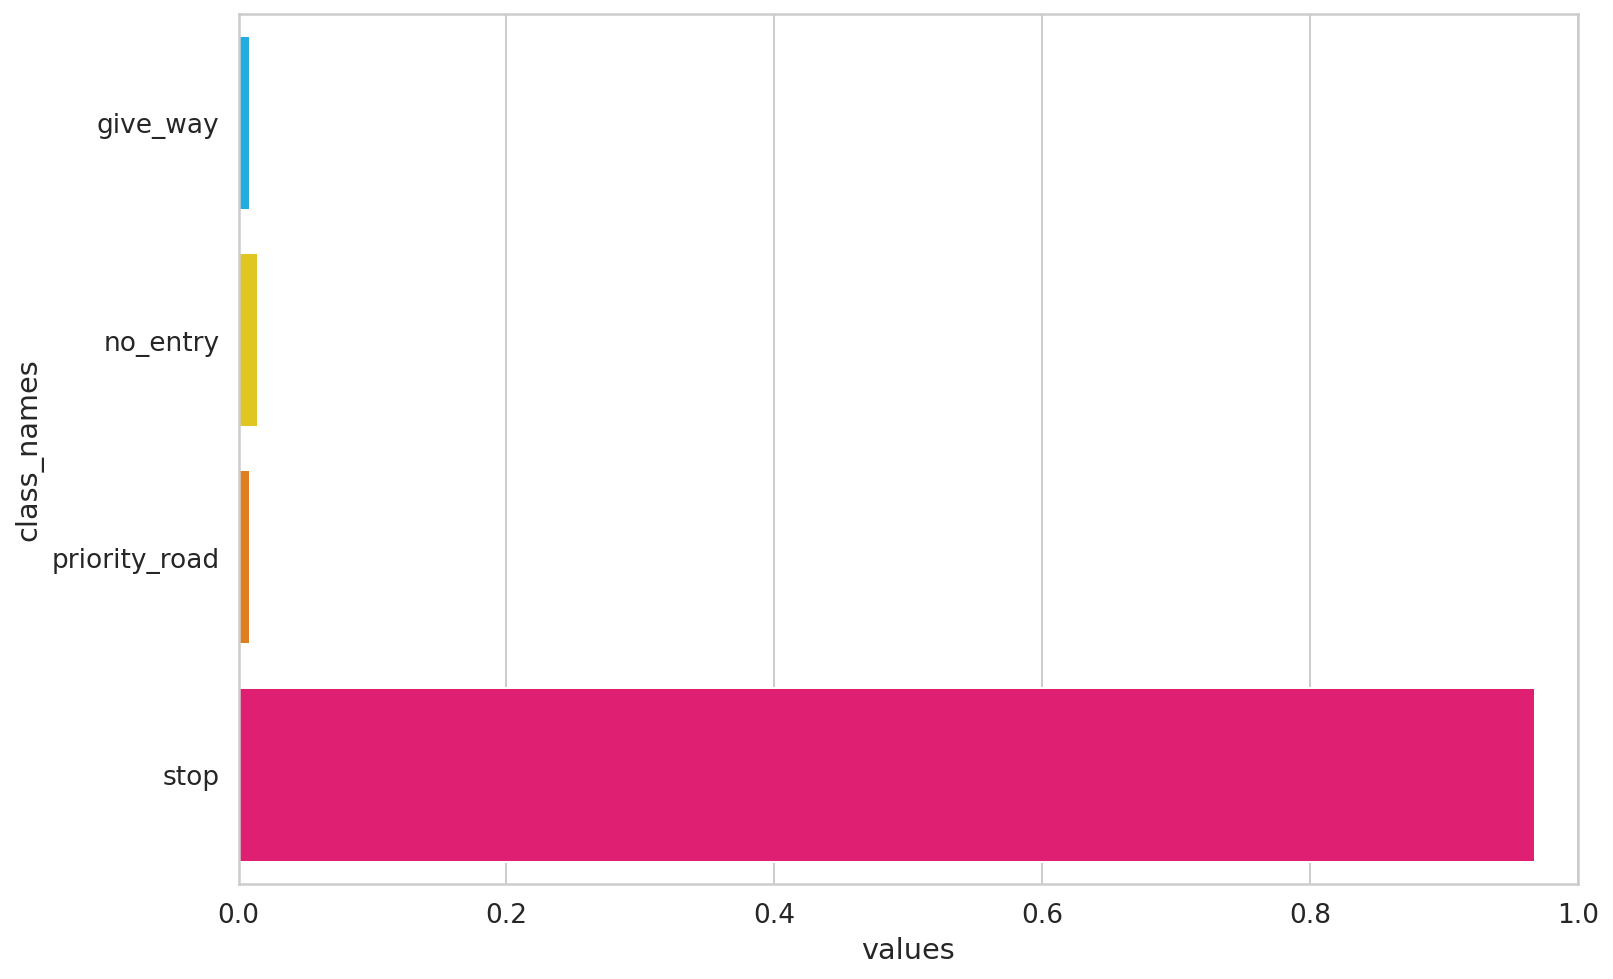

In [ ]:
show_prediction_confidence(pred, class_names)

### Classyfing unknown traffic sign

In [ ]:
!gdown --id 1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u
To: /content/unknown-sign.jpg
100% 41.4k/41.4k [00:00<00:00, 57.6MB/s]


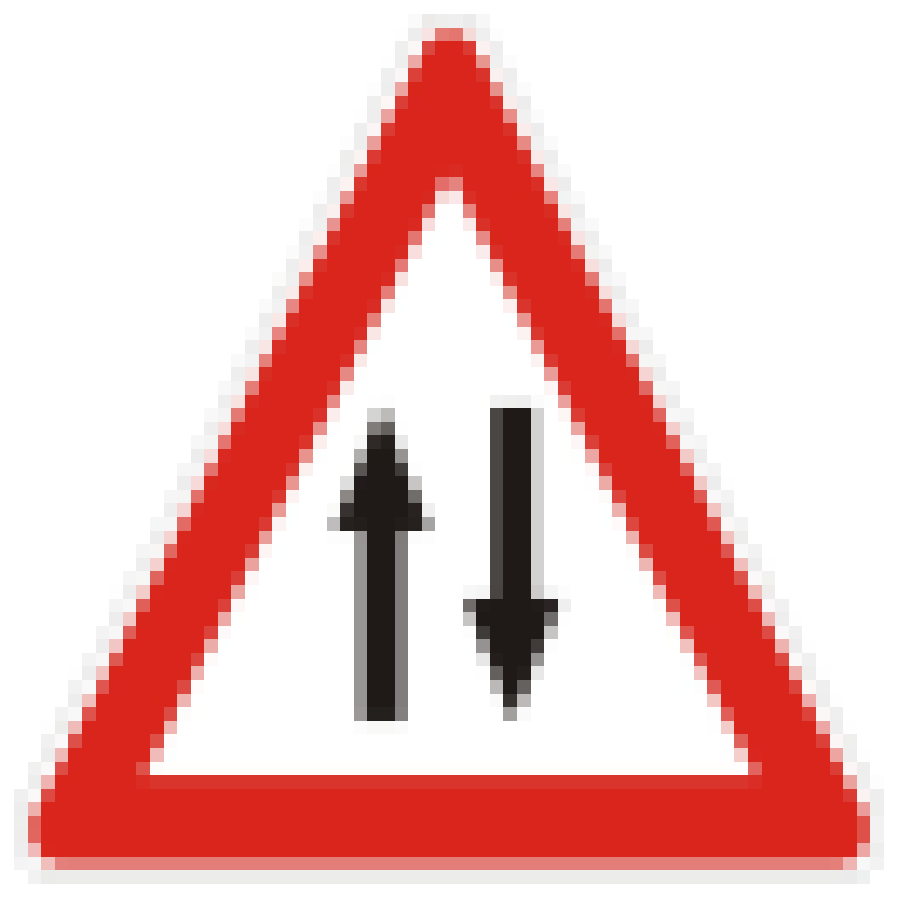

In [ ]:
show_image('unknown-sign.jpg')

predictions:

In [ ]:
pred = predict_probabilty(base_model, 'unknown-sign.jpg')
pred

array([9.9960440e-01, 1.6709873e-05, 1.0650316e-04, 2.7234788e-04],
      dtype=float32)

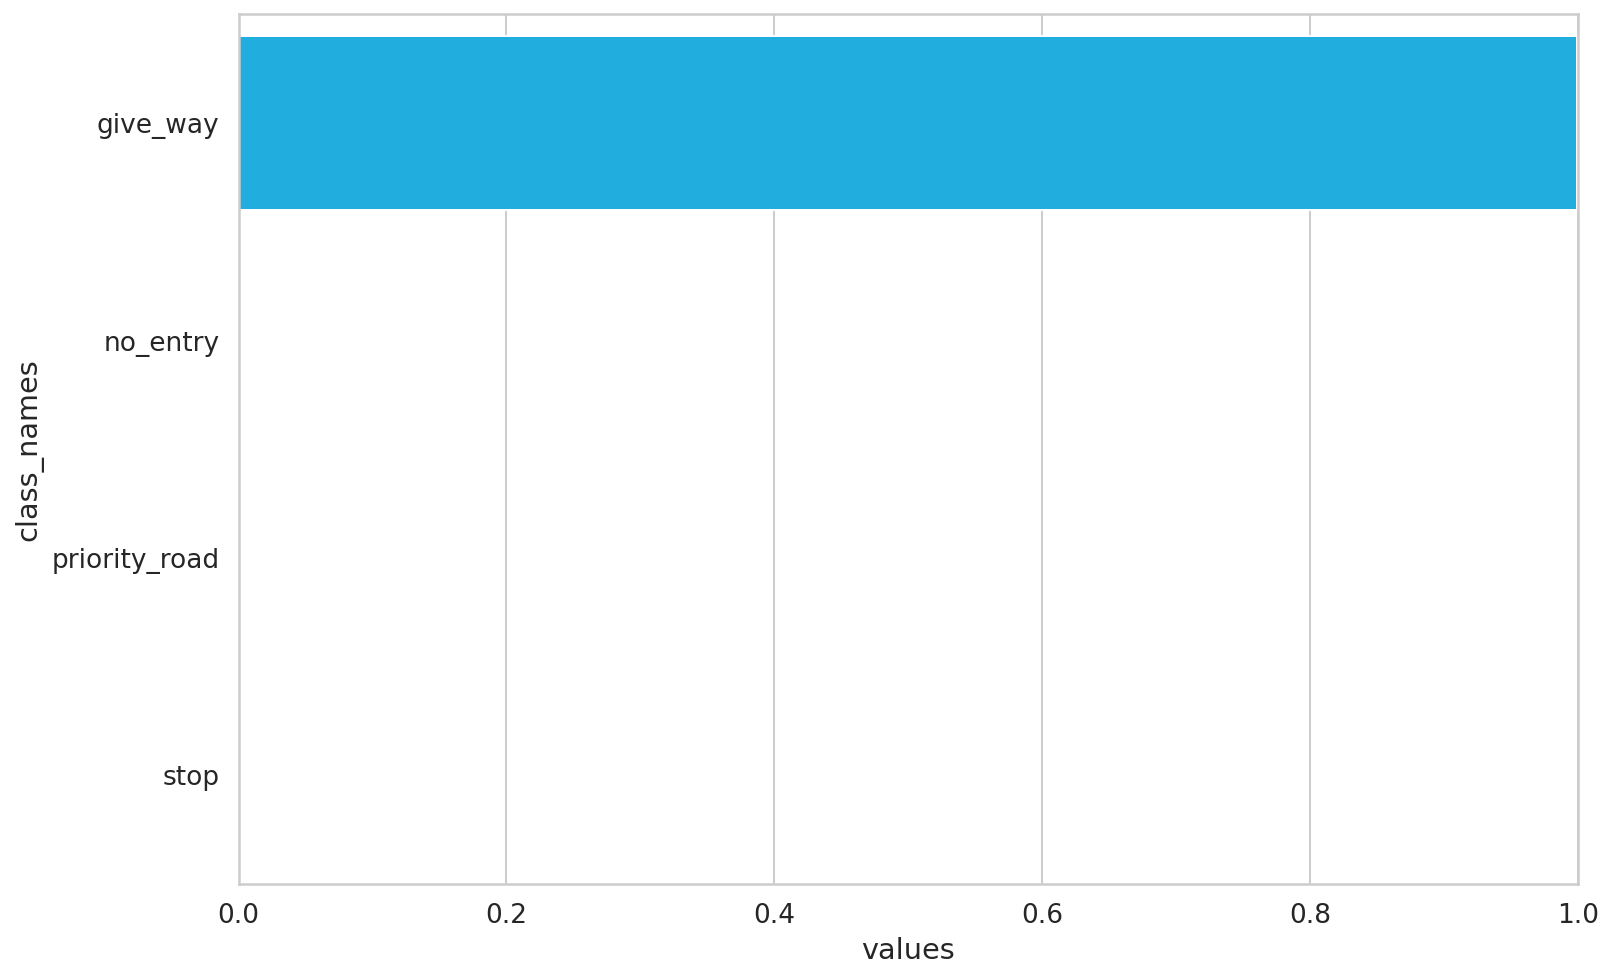

In [ ]:
show_prediction_confidence(pred, class_names)

## Adding class "unknown"


In [ ]:
unknown_indices = [
  i for i, f in enumerate(train_folders) \
  if i not in class_indices
]

len(unknown_indices)

39

We'll create a new folder for the unknown class and copy some of the images there:

In [ ]:
for ds in DATASETS:
  (DATA_DIR / ds / 'unknown').mkdir(parents=True, exist_ok=True)

for ui in unknown_indices:
  image_paths = np.array(glob(f'{train_folders[ui]}/*.ppm'))
  image_paths = np.random.choice(image_paths, 50)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/unknown/')

The next steps are identical to what we've already done:

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'train': 5683, 'val': 791, 'test': 790}

In [ ]:
%%time

enchanced_model = create_model(len(class_names))
enchanced_model, history = train_model(enchanced_model, data_loaders, dataset_sizes, device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/3
----------
Train loss 0.38076839184413586 accuracy 0.8759458032729193
Val   loss 0.021105768998311743 accuracy 0.9936788874841973

Epoch 2/3
----------
Train loss 0.17248137546656317 accuracy 0.9440436389231041
Val   loss 0.014392027349612537 accuracy 0.9924146649810367

Epoch 3/3
----------
Train loss 0.13109646621776694 accuracy 0.9604082350871019
Val   loss 0.0016927508747847132 accuracy 1.0

Best val accuracy: 1.0
CPU times: user 2min 39s, sys: 6.75 s, total: 2min 45s
Wall time: 2min 51s


history['train_acc'] : [tensor(0.8759, device='cuda:0', dtype=torch.float64), tensor(0.9440, device='cuda:0', dtype=torch.float64), tensor(0.9604, device='cuda:0', dtype=torch.float64)]
history['val_acc'] : [tensor(0.9937, device='cuda:0', dtype=torch.float64), tensor(0.9924, device='cuda:0', dtype=torch.float64), tensor(1., device='cuda:0', dtype=torch.float64)]
train_accuracy_list : [0.8759458032729193, 0.9440436389231041, 0.9604082350871019]
validation_accuracy_list : [0.9936788874841973, 0.9924146649810367, 1.0]


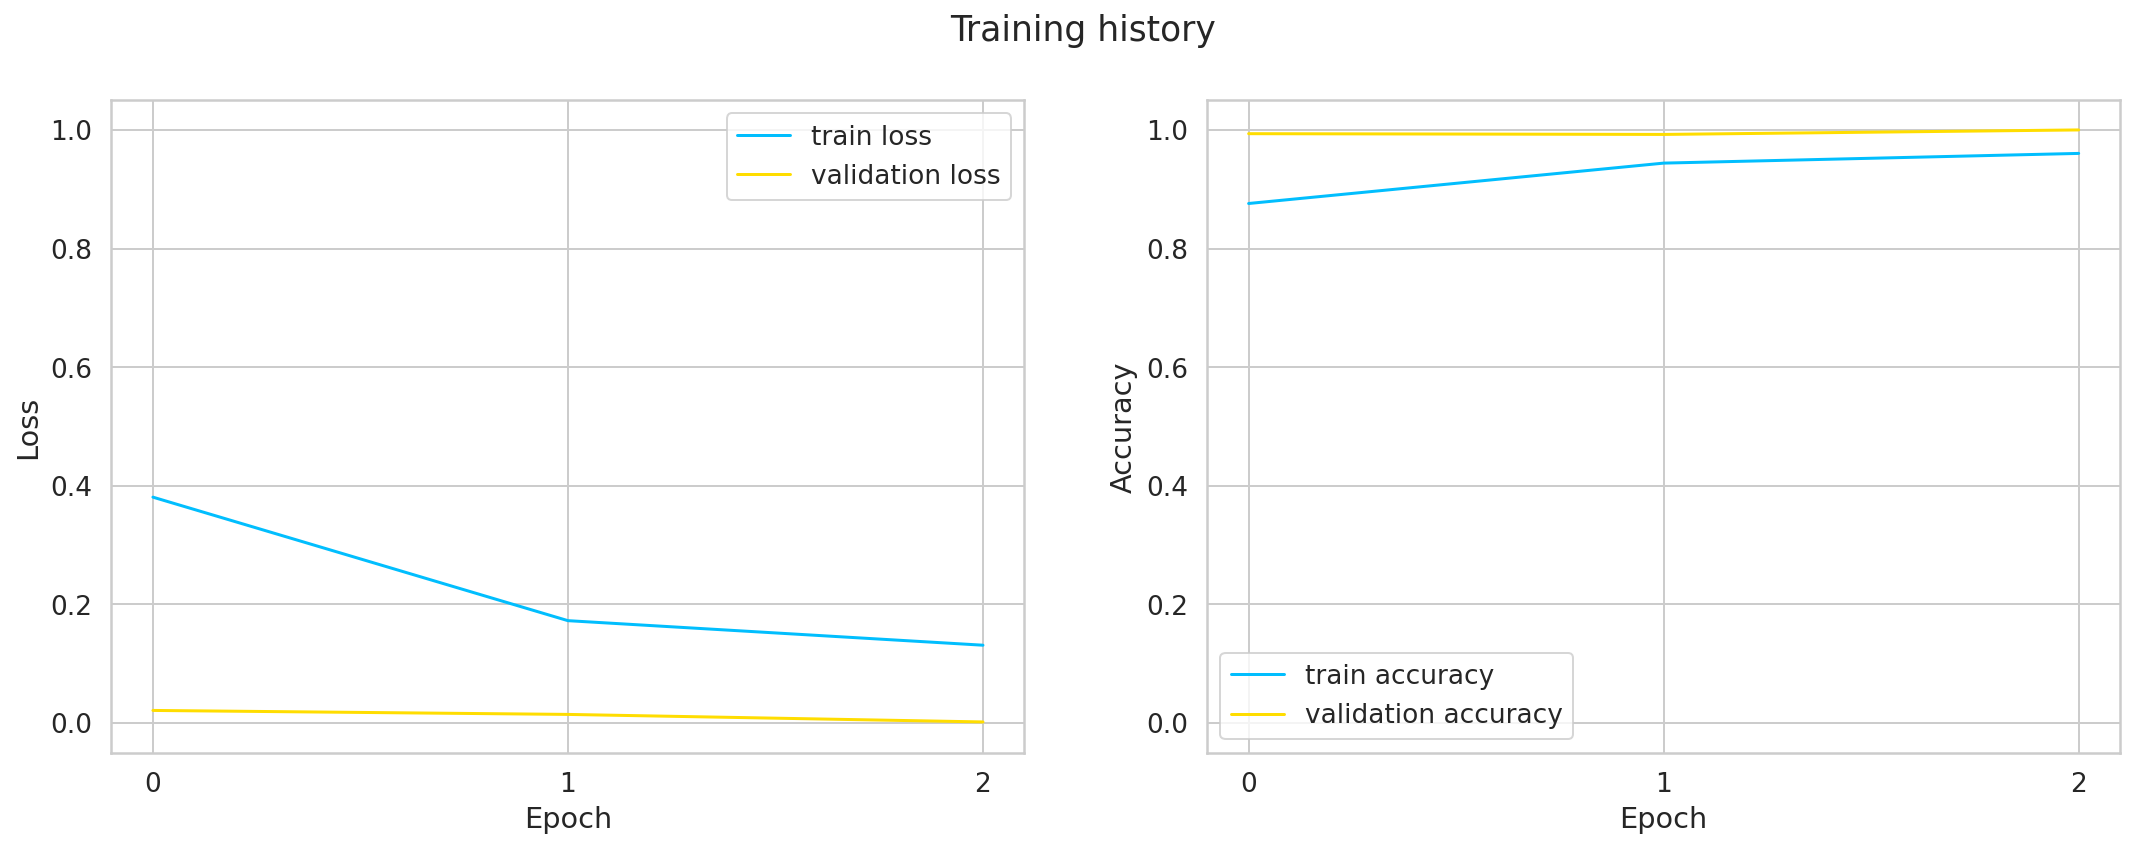

In [ ]:
plot_training_history(history)

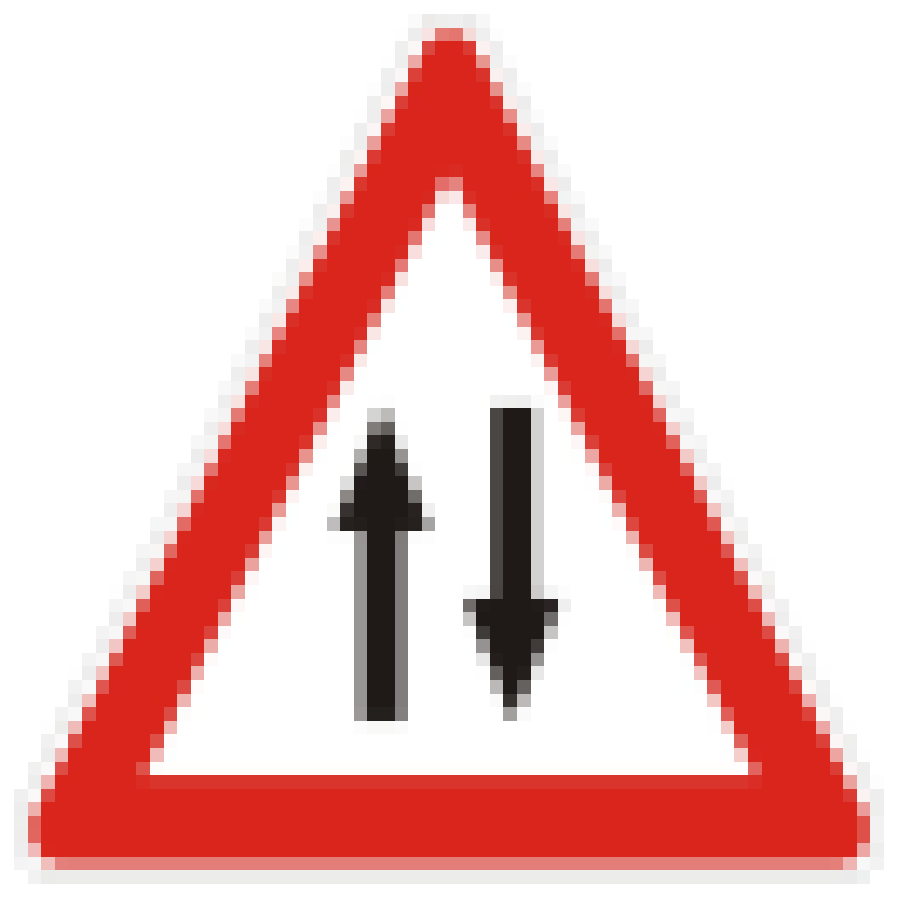

In [ ]:
show_image('unknown-sign.jpg')

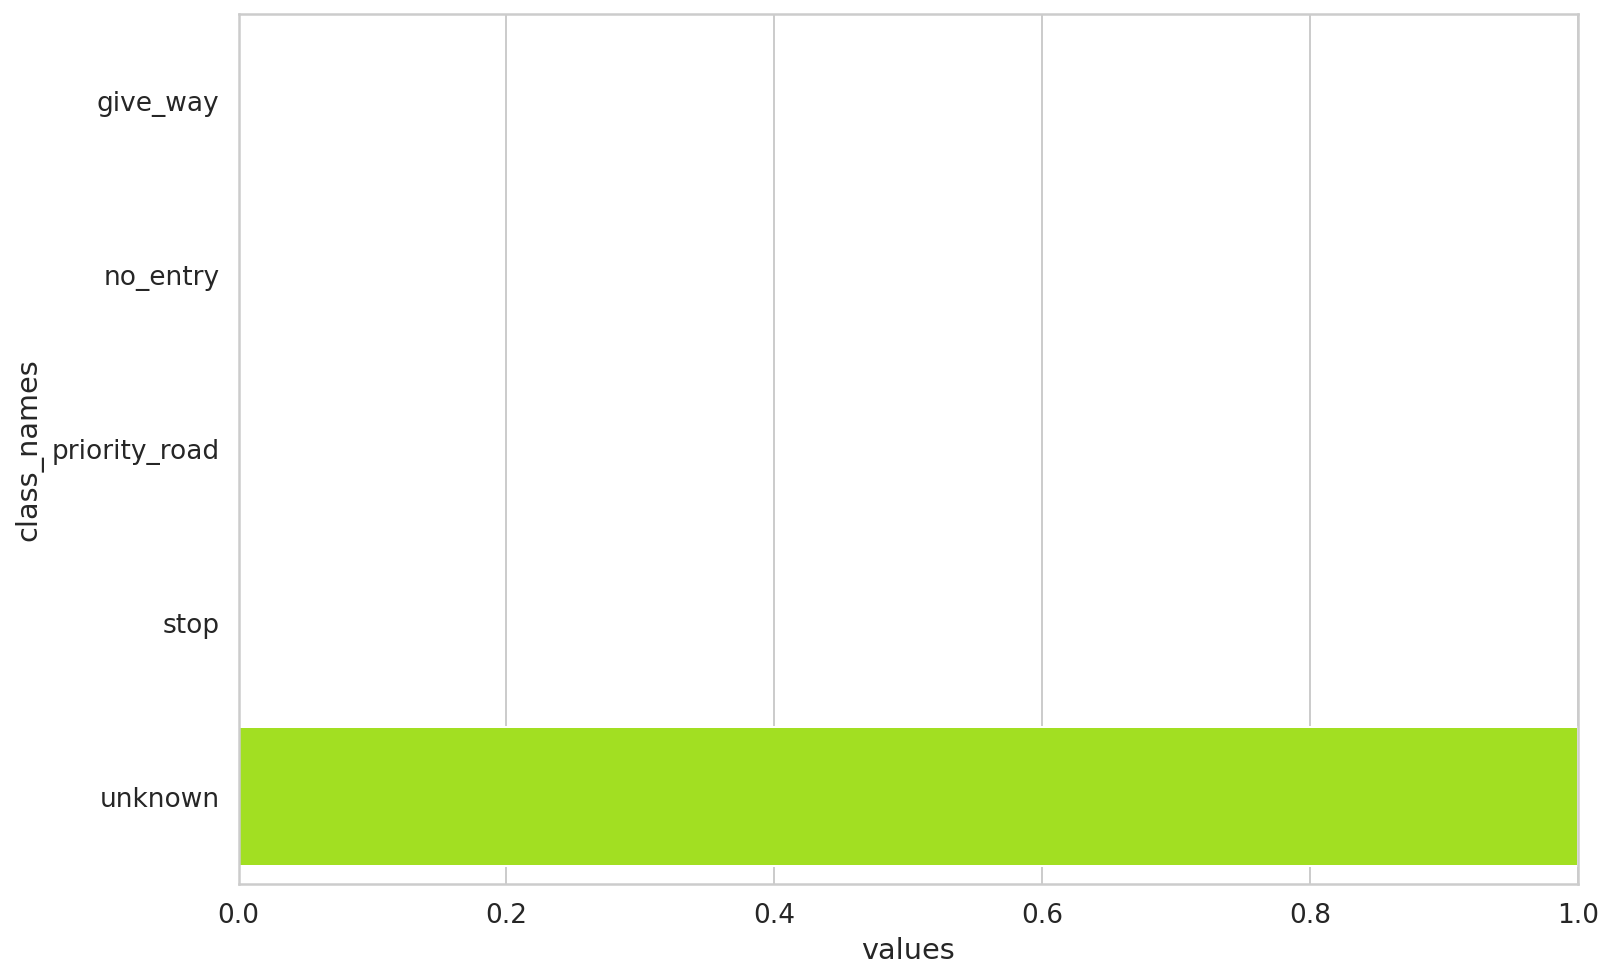

In [ ]:
pred = predict_probabilty(enchanced_model, 'unknown-sign.jpg')
show_prediction_confidence(pred, class_names)

the model doesn't give much weight to any of the known classes. It doesn't know that this is a two-way sign, but recognizes is as unknown.

examples of our new dataset:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


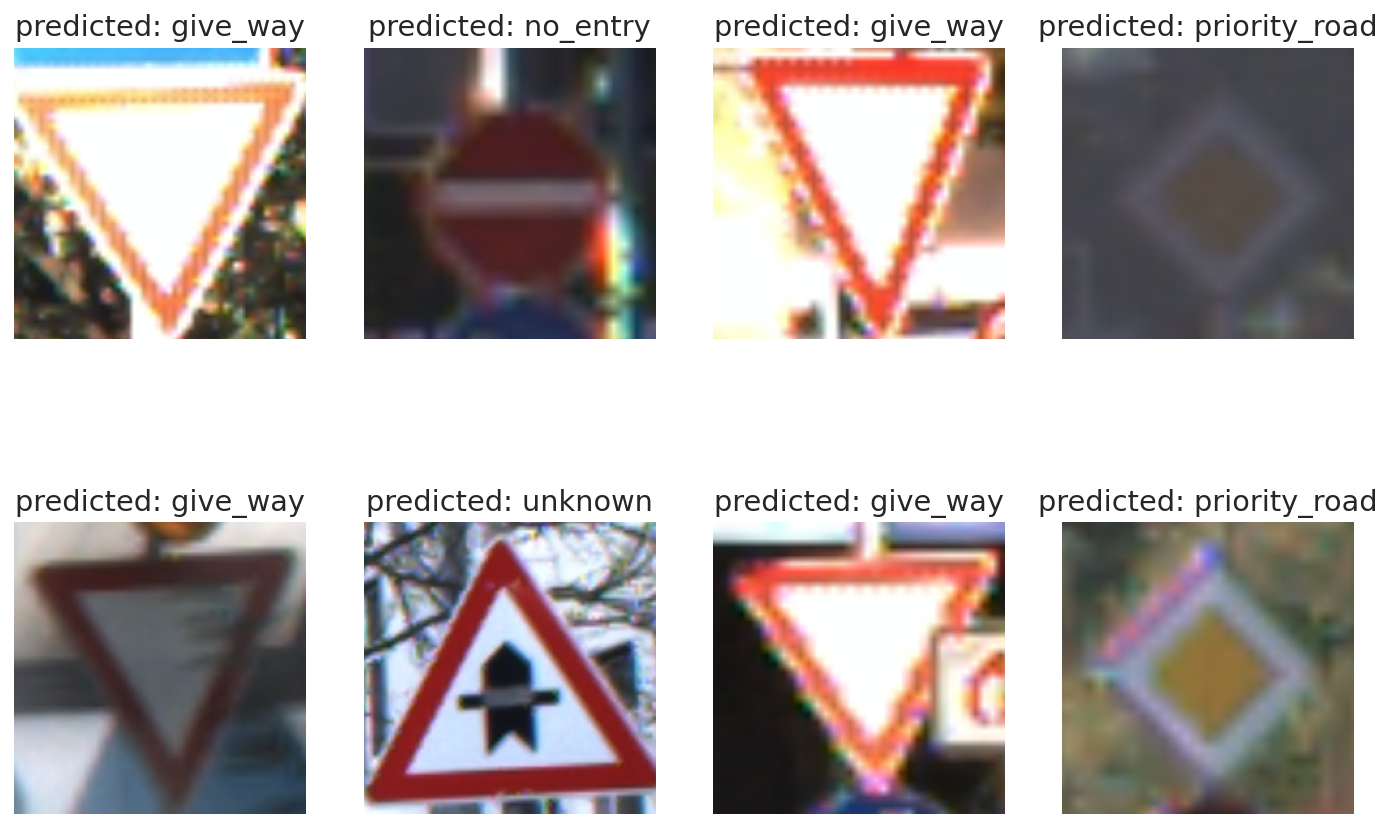

In [ ]:
show_predictions(enchanced_model, class_names, n_images=8)

model's performance:

In [ ]:
y_pred, y_test = get_predictions(enchanced_model, data_loaders['test'])

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

     give_way       1.00      1.00      1.00       216
     no_entry       1.00      1.00      1.00       111
priority_road       1.00      1.00      1.00       210
         stop       0.99      1.00      0.99        78
      unknown       1.00      0.99      0.99       175

     accuracy                           1.00       790
    macro avg       1.00      1.00      1.00       790
 weighted avg       1.00      1.00      1.00       790



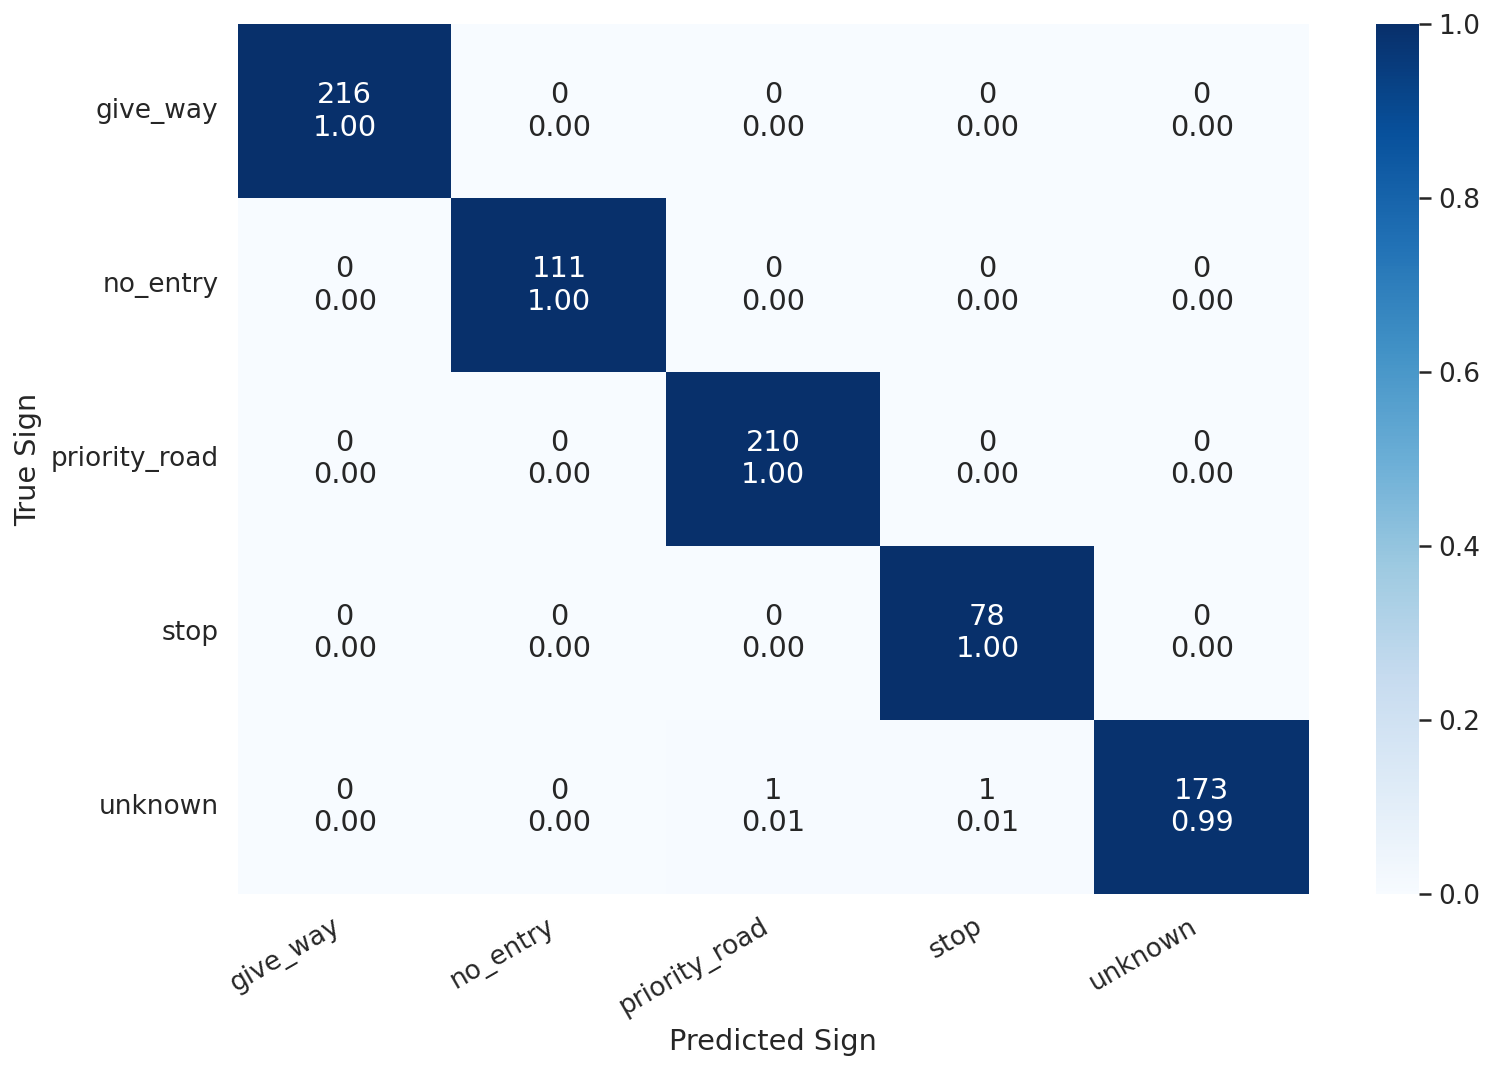

In [ ]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names  )